# Chemotaxonomy

Hiearchical clustering of plants based on their chemical composition

### Import modules

In [1]:
from collections import defaultdict
from ast import literal_eval
import itertools as itt
import math
from typing import Dict, Set, Any
import pickle

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

# Import taxonomy
from utils import get_genus_and_family_info_for_plants

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

from rdkit.DataStructs import TanimotoSimilarity
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit import RDLogger  

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 360
%matplotlib inline

In [4]:
tqdm.pandas()
pd.set_option('display.max_columns', None)

Load chemicals

In [5]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [6]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [7]:
len(plant_chemical_df.chemical_curie.unique()), len(plant_chemical_df.plant_curie.unique())

(71179, 18094)

Convert the SMILEs to PubChem ids

In [8]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_id',
        'smiles',
    ],
)

In [9]:
smiles_dict = {}
for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    smiles_dict[pubchem_id] = smiles  

100%|██████████| 71179/71179 [00:00<00:00, 539291.47it/s]


In [10]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 71179/71179 [00:00<00:00, 477151.23it/s]


### Calculate chemical similarity across all pairs of chemicals

In [11]:
# make a list of mols
pubchem_to_mol = {
    pubchem: Chem.MolFromSmiles(smiles)
    for pubchem, smiles in pubchem_to_smiles.items()
}

# pubchem morgan
pubchem_to_morgan = {
    pubchem: rdMolDescriptors.GetMorganFingerprint(mol, 2)
    for pubchem, mol in pubchem_to_mol.items()
}

In [12]:
len(pubchem_to_morgan)

71179

Calculate similarities

In [13]:
precalculated_similarities = defaultdict(dict)

In [ ]:
num_combinations = math.factorial(len(pubchem_to_morgan)) / (math.factorial(2) * math.factorial(len(pubchem_to_morgan) - 2))

for chem_a, chem_b in tqdm(
    itt.combinations_with_replacement(pubchem_to_morgan.keys(), r=2),
    total=num_combinations,
):
    
    sim = TanimotoSimilarity(
        pubchem_to_morgan[chem_a],
        pubchem_to_morgan[chem_b],
    )
    
    precalculated_similarities[chem_a][chem_b] = sim
    precalculated_similarities[chem_b][chem_a] = sim

 71%|███████▏  | 1809378766/2533189431.0 [9:32:58<10054:05:40, 20.00it/s]

In [ ]:
with open('precalculated_similarities.pickle', 'wb') as file:
    # dump the object into the file
    pickle.dump(precalculated_similarities, file)

### Create similarity matrix

In [ ]:
plant_chem_dict = defaultdict(set)
chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)

Tag chemicals that are prenent in more than 100 plants, since they are likely to be common primary metabolites

In [ ]:
promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 100
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

In [ ]:
g = sns.displot(
    [
        len(plants)
        for chemical, plants in chemicals_to_plant_dict.items()
        if chemical not in promiscuous_chemicals
    ],
    kind="kde",
    height=4,
    aspect=2,
)

g.set_axis_labels("Number of plants", "Density")
g.set_titles("Distribution of plants per chemical")

plt.show()

Build the similarity matrix

In [ ]:
def calculate_plant_similarity(
    plant_a: str,
    plant_b: str,
    plant_to_chemicals: Dict[str, Set[str]],
    pubchem_to_morgan: Dict[str, Any],
    top_percentage: int,
    skipped: Set[str],
):
    """Calculate the similarity between two plants."""
    similarities = []
    for chemical_plant_a, chemical_plant_b in itt.product(plant_to_chemicals[plant_a], plant_to_chemicals[plant_b]):
        
        similarities.append(
            TanimotoSimilarity(
                pubchem_to_morgan[chemical_plant_a],
                pubchem_to_morgan[chemical_plant_b],
            )
        )
        
    top_percentage = int((len(plant_to_chemicals[plant_a]) * len(plant_to_chemicals[plant_b])) / top_percentage)
    
#     print(f"{top_percentage} from {len(plant_to_chemicals[plant_a])} / {len(plant_to_chemicals[plant_b])}")
    
    return sum(sorted(similarities, reverse=True)[:top_percentage]) / top_percentage


In [ ]:
def num_combinations(n, r):
    return math.factorial(n) // (math.factorial(r) * math.factorial(n-r))

In [ ]:
plant_curies = [
    plant
    for plant in plant_chemical_df.plant_curie.unique()
    if plant in plant_chem_dict and len(plant_chem_dict[plant]) > 20
]

print(f'{len(plant_curies)} plants included in the analysis')

skipped_chemicals = set()

similarity_dataframe = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

for plant_a, plant_b in tqdm(
    itt.combinations_with_replacement(plant_curies, r=2),
    total=num_combinations(len(plant_curies), 2),
):

    sim = calculate_plant_similarity(
        plant_a=plant_a,
        plant_b=plant_b,
        plant_to_chemicals=plant_chem_dict,
        pubchem_to_morgan=pubchem_to_morgan,
        top_percentage=10,
        skipped=skipped_chemicals,
    )
    
    similarity_dataframe[plant_a][plant_b] = sim
    similarity_dataframe[plant_b][plant_a] = sim

In [14]:
plant_chem_dict = defaultdict(set)
chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)

100%|██████████| 330655/330655 [00:00<00:00, 461115.04it/s]


Tag chemicals that are prenent in more than 100 plants, since they are likely to be common primary metabolites

In [15]:
promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 100
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

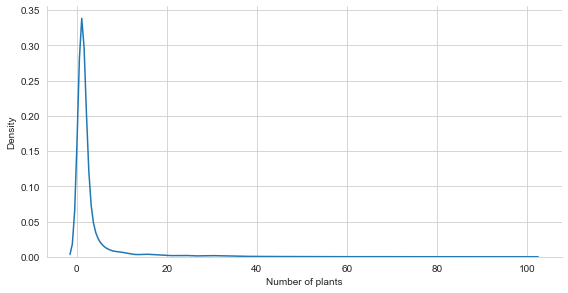

In [16]:
g = sns.displot(
    [
        len(plants)
        for chemical, plants in chemicals_to_plant_dict.items()
        if chemical not in promiscuous_chemicals
    ],
    kind="kde",
    height=4,
    aspect=2,
)

g.set_axis_labels("Number of plants", "Density")
g.set_titles("Distribution of plants per chemical")

plt.show()

Build the similarity matrix

In [17]:
def calculate_plant_similarity(
    plant_a: str,
    plant_b: str,
    plant_to_chemicals: Dict[str, Set[str]],
    pubchem_to_morgan: Dict[str, Any],
    top_percentage: int,
    skipped: Set[str],
):
    """Calculate the similarity between two plants."""
    similarities = []
    for chemical_plant_a, chemical_plant_b in itt.product(plant_to_chemicals[plant_a], plant_to_chemicals[plant_b]):
        
        similarities.append(
            TanimotoSimilarity(
                pubchem_to_morgan[chemical_plant_a],
                pubchem_to_morgan[chemical_plant_b],
            )
        )
        
    top_percentage = int((len(plant_to_chemicals[plant_a]) * len(plant_to_chemicals[plant_b])) / top_percentage)
    
#     print(f"{top_percentage} from {len(plant_to_chemicals[plant_a])} / {len(plant_to_chemicals[plant_b])}")
    
    return sum(sorted(similarities, reverse=True)[:top_percentage]) / top_percentage


In [18]:
def num_combinations(n, r):
    return math.factorial(n) // (math.factorial(r) * math.factorial(n-r))

In [ ]:
plant_curies = [
    plant
    for plant in plant_chemical_df.plant_curie.unique()
    if plant in plant_chem_dict and len(plant_chem_dict[plant]) > 20
]

print(f'{len(plant_curies)} plants included in the analysis')

skipped_chemicals = set()

similarity_dataframe = pd.DataFrame(
    0.0,
    index=plant_curies,
    columns=plant_curies,
)

for plant_a, plant_b in tqdm(
    itt.combinations_with_replacement(plant_curies, r=2),
    total=num_combinations(len(plant_curies), 2),
):

    sim = calculate_plant_similarity(
        plant_a=plant_a,
        plant_b=plant_b,
        plant_to_chemicals=plant_chem_dict,
        pubchem_to_morgan=pubchem_to_morgan,
        top_percentage=10,
        skipped=skipped_chemicals,
    )
    
    similarity_dataframe[plant_a][plant_b] = sim
    similarity_dataframe[plant_b][plant_a] = sim

3249 plants included in the analysis


  0%|          | 13512/5276376 [01:20<20:50:31, 70.14it/s] 

In [ ]:
# Create the dissimilarity matrix for each row of the similarity matrix using 1-s where s is the similarity
distance_matrix = pdist(
    similarity_dataframe,
    metric='correlation', # TODO: check other metrics!
)

Potentially check this if there are errors
https://github.com/ComPath/ComPath/blob/26c43da61a0329f56013d3e3b39d83cf0a127134/src/compath/visualization/d3_dendrogram.py#L142

In [ ]:
# Calculate clusters
Z = linkage(
    distance_matrix,
    method='average',  # check others?
)

dn = dendrogram(Z)
plt.show()

# TODO: Get clusters using a cutoff

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

### Get the real taxonomical clusters

In [ ]:
genus_to_species, family_to_species = get_genus_and_family_info_for_plants(
    set(plant_chemical_df.plant_curie.unique()),
)

# TODO: Evaluate the goodness of the chemotaxonomy

In [ ]:
Use this package: https://github.com/hhromic/python-bcubed
        